In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob
from scipy.stats import wilcoxon
from scipy.spatial.distance import jensenshannon
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE

global_palette = {'Raw':'#4c72b0', 'Restrictive':'#dd8452',
                  'Decontam':'#55a868', 'SCRUB':'#c44e52', 'SCRuB':'#c44e52', 
                  'Decontam (Low Biomass)':'darkgreen',
                  'Decontam (LB)':'darkgreen',
                  'Decontam_LB':'darkgreen',
                  'Restrictive (Original)':'#dd8452',
                  'Input':'#4c72b0',
                  'No decontamination':'#4c72b0', 
                  'microDecon':'purple'}
sns.set_theme(font_scale=2)

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 
            'axes.edgecolor':'black', 
           'grid.color': 'black'}, 
       font_scale=2)

## decontamination boxplot

In [279]:
specs = pd.read_csv('20220926_16S_Decontamination.220929.asvTable.csv').Species


def transform_to_species(b):
    return( pd.concat([ b.T.reset_index(drop=True), specs], axis=1).groupby('Species').sum().T )


decontaminated_samples = { a.split('/')[1][:-7]:transform_to_species( 
                                                    pd.read_csv(a, index_col=0) )
                          for a in glob.glob('final_decontaminations/*')
                            if 'predicted' not in a }

In [281]:
raw_data = pd.read_csv('20220926_16S_Decontamination.220929.asvTable.csv', 
                              index_col=0).T.iloc[:-7]

decontaminated_samples['No decontamination'] = \
            transform_to_species(raw_data)


In [282]:
decontaminated_samples['No decontamination']=\
        decontaminated_samples['No decontamination'].loc[decontaminated_samples['SCRuB'].index]

In [283]:
def calculate_dists(b):
    smps = []
    dists = []

    for ind in b.loc[b.index.str.startswith('Z')].index:
        if ind[:3] == 'ZSV':
            if b.loc[b.index.str.startswith('V3' + ind[1:4])].shape[0] > 0:
                smps.append(ind)
                dists.append( ( jensenshannon( b.loc[b.index.str.startswith('V3'+ ind[1:4])].values[0], 
                                      decontaminated_samples['No decontamination'].loc[ind].values
                                    ) ) )
        else:
            if b.loc[b.index.str.startswith(ind[1:4])].shape[0] > 0:

                smps.append(ind)
                dists.append( ( jensenshannon( b.loc[b.index.str.startswith(ind[1:4])].values[0], 
                                      decontaminated_samples['No decontamination'].loc[ind].values
                                    ) ) )

    return( pd.DataFrame({'Sample': smps, 
                      'JSD': dists}) )

In [288]:
performances = {a:calculate_dists(b) for a,b in decontaminated_samples.items()}


for a in performances:
    performances[a]['Method'] = a
    performances[a]['Sample type'] = performances[a].Sample.str[1:3]
    
all_performances = pd.concat( [b for a,b in performances.items() ] )


all_performances=all_performances.loc[
                all_performances['Sample type'].isin(['ST', 'SV'])
                                        ]

In [289]:
all_performances=all_performances.sort_values('Sample')

In [290]:
all_performances['Sample type']=True

               Method  Sample type  sig_v_scrub
5         Restrictive         True     0.000061
5               SCRuB         True     1.000000
5            Decontam         True     0.000061
5          microDecon         True     0.000061
5       Decontam (LB)         True     0.000061
5  No decontamination         True     0.000061


/Users/george/opt/anaconda3/envs/qiime2-dev/lib/python3.8/site-packages/seaborn/categorical.py:1402: UserWarning: You passed a edgecolor/edgecolors ('#1e1e1e') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(cat_pos, swarm_data, s=s, **kws)
/Users/george/opt/anaconda3/envs/qiime2-dev/lib/python3.8/site-packages/seaborn/categorical.py:1402: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(cat_pos, swarm_data, s=s, **kws)


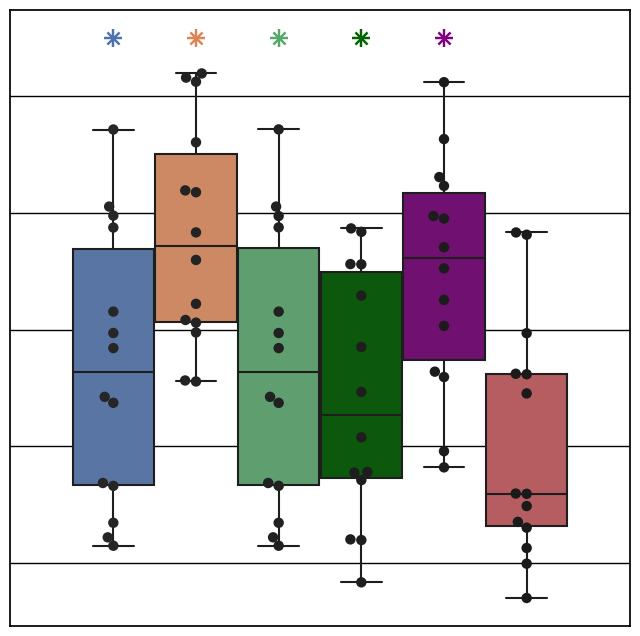

In [293]:
plt.figure(figsize=(8,8))
ax=sns.boxplot(x='Sample type', 
            y='JSD', 
            hue='Method', 
            data=all_performances,
            palette=global_palette, 
            hue_order = ['No decontamination', 
                         'Restrictive',
                         'Decontam', 
                         'Decontam (LB)', 
                         'microDecon',
                         'SCRuB']
              )

ax=sns.swarmplot(x='Sample type', 
            y='JSD', 
            hue='Method', 
            data=all_performances, 
            hue_order = ['No decontamination', 
                         'Restrictive',
                         'Decontam', 
                         'Decontam (LB)', 
                         'microDecon',
                         'SCRuB'], 
                 s=7.5, 
                 dodge=True, 
                 color='k', 
                 ax=ax
              )


tmp=all_performances.copy()
    
    # plot vs raw significance asterisks
q=all_performances[['Method', 'Sample type']].drop_duplicates()
q['sig_v_scrub'] = q.apply(lambda row: [ wilcoxon( 
            tmp.loc[ (tmp.Method==row.Method)&(tmp['Sample type']==row['Sample type'])]['JSD'].values, 
    tmp.loc[ (tmp.Method=='SCRuB')&(tmp['Sample type']==row['Sample type']) ]['JSD'].values, 
    alternative='greater').pvalue
                    if row.Method!='SCRuB' else 1][0],
       axis=1)

print(q)

q['y_val']= 0.55
# q['y_val']= 0.9
q['is_sig'] =  q.sig_v_scrub < 1e-2

sns.swarmplot( x='Sample type', y='y_val', hue='Method',
                data = q.loc[q.is_sig], 
#                order = ['ST', 'SV'],
           hue_order = ['No decontamination', 'Restrictive', 'Decontam', 'Decontam (LB)', 'microDecon', 'SCRUB'],
               marker='+',
              size=25/2, 
                ax=ax,
                palette=global_palette, 
              dodge=True, 
              color='black',
              linewidth=3.5/2
               )

sns.swarmplot( x='Sample type', y='y_val', hue='Method',
                data = q.loc[q.is_sig], 
#                order = ['ST', 'SV'],
           hue_order = ['No decontamination', 'Restrictive', 'Decontam', 'Decontam (LB)', 'microDecon', 'SCRUB'],
               marker='x',
              size=17.5/2,
                ax=ax,
                palette=global_palette, 
              dodge=True, 
              color='black',
              linewidth=3.5/2,
                edgecolor="black"
               )

plt.ylabel(None)
plt.xlabel(None)
ax.set_yticks(ticks=[.1, .2, .3, .4, .5], labels=[])
ax.set_xticks(ticks=[1], labels=[])
ax.legend().remove()

## TSNE plots

In [294]:

def set_up_tsne_plot(df_, condition='Z|z|neg2_3_2'):
#     df = transform_to_species(raw_data)
    df=df_.loc[(df_.sum(axis=1) > 5000 )|(df_.index.str.contains('neg'))] #8000
    df=df.loc[df.index.str.contains(condition)] 
    z_abunds=df.div(df.sum(axis=1), axis=0)

#     z_abunds=df.div(df.sum(axis=1), axis=0)

#     z_abunds=z_abunds.sort_index()

    z_grps= z_abunds.index.str.split('_').str[0].str[1:-1].values

    z_grps[ z_abunds.index.str.contains('neg2_10|neg2_9') ] = 'Blank'
    z_grps[ ['eg' in a for a in z_grps] ] = \
            ['SK', 'ST', 'ST', 'SK', 'SV', 'SV', 'VG', 'VG']
    
    return(z_abunds, z_grps)



In [295]:
smp_col_dict = {'ST':'sienna', 
                'SK':'bisque', 
                'SV':'lightblue',
                'VG':'pink', 
                'neg':'white', 
                'Blank':'white', 
                'amm':'red'
                }

In [296]:
z_abunds, z_grps = set_up_tsne_plot( raw_data )

/Users/george/opt/anaconda3/envs/qiime2-dev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


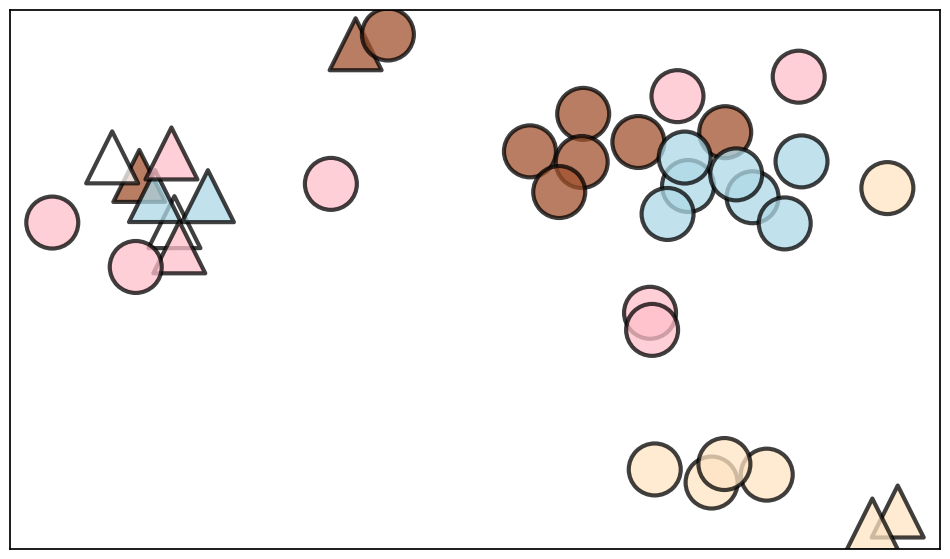

In [297]:
np.random.seed(54321)
ts=TSNE(n_components=2, perplexity=4, learning_rate=200)

X=ts.fit_transform(z_abunds.values)


plt.figure(figsize=(12,7) )
ax=sns.scatterplot(X[:, 0], X[:, 1], hue = z_grps, s=1400, 
                   palette=smp_col_dict, 
                   style=z_abunds.index.str.split('_').str[0].str[1:-1].values,
                  markers= {'SK':'o', 'ST':'o', 'SV':'o', 'VG':'o', 'neg':'^', 'eg':'^'}, 
                   alpha=.75, 
                   edgecolor="black")
#                    np.array( [ '^' if 'neg' in a)
ax.legend().remove()


hide_axes=True
if hide_axes:
        plt.xlabel(None)
        plt.ylabel(None)
        plt.xticks([])
        plt.yticks([])

In [298]:
df_tmp=pd.read_csv('final_decontaminations/SCRuBout.csv', 
                             index_col=0)

df_tmp.columns = raw_data.columns
                

In [299]:
predicted_cont = pd.read_csv('final_decontaminations/predicted_plate1_contaminant.csv')
predicted_cont.index = raw_data.columns
predicted_cont=predicted_cont.T
predicted_cont.index= ['Gamma']

In [300]:
df = pd.concat( [df_tmp, 
                 predicted_cont,
                 raw_data.loc[raw_data.index.str.contains('neg2_10|neg2_9')] ], 
                 axis=0)

df=df.loc[df.index.str.contains('Z|z|neg2_3_2|Gamma')] 
z_abunds=df.div(df.sum(axis=1), axis=0)

z_grps= z_abunds.index.str.split('_').str[0].str[1:-1].values

/Users/george/opt/anaconda3/envs/qiime2-dev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


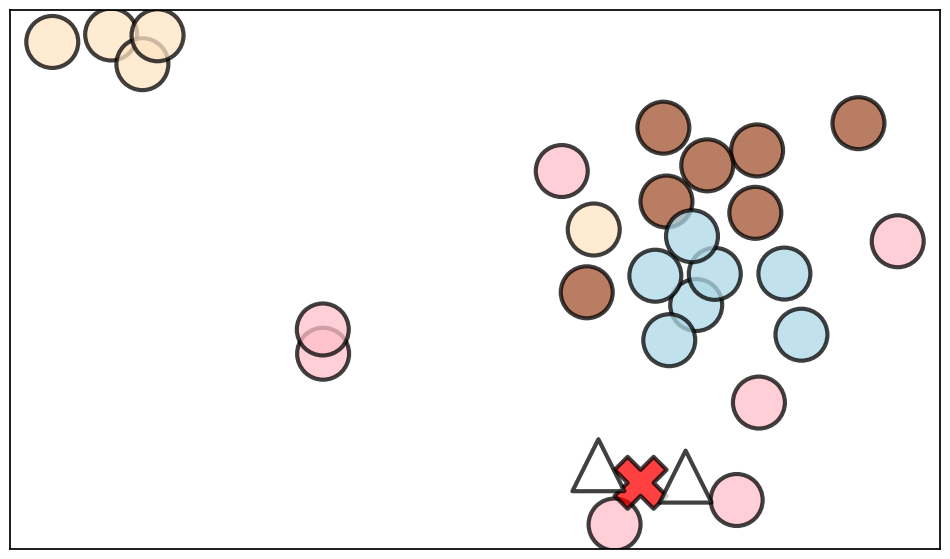

In [306]:
np.random.seed(2022)

ts=TSNE(n_components=2, perplexity=4, learning_rate=200)
X=ts.fit_transform(z_abunds.values)

# X = pcoa(bc_distmat).samples.values

plt.figure(figsize=(12,7) )
ax=sns.scatterplot(X[:, 0], X[:, 1], hue = z_grps, s=1400, 
                   palette=smp_col_dict, 
                   style=z_abunds.index.str.split('_').str[0].str[1:-1].values,
                  markers= {'SK':'o', 
                            'ST':'o', 
                            'SV':'o', 
                            'VG':'o', 
                            'neg':'^', 
                            'eg':'^', 
                            'amm':'X'}, 
                   alpha=.75, 
                   edgecolor="black"
                  )
ax.legend().remove()


hide_axes=True
if hide_axes:
        plt.xlabel(None)
        plt.ylabel(None)
        plt.xticks([])
        plt.yticks([])

# ROC curves

In [316]:

predicted_conts = pd.read_csv('final_decontaminations/predicted_contaminants.csv',
                             )[['Genus', 
                                 'zymo', 'Restrictive', 'Decontam', 
                                'Decontam (LB)', 'microDecon', 'SCRuB']]


predicted_conts=predicted_conts[['Genus', 
                                 'zymo', 'Restrictive', 'Decontam', 
                                'Decontam (LB)', 'microDecon', 'SCRuB']]

In [317]:
from sklearn.metrics import roc_curve, auc

In [318]:
def create_roc_dataset(df, 
                       col, 
                       perc1_abund = .01 * predicted_conts.zymo.sum()):

    curve=roc_curve(df.zymo>perc1_abund,
                      df[col], 
                    drop_intermediate=False
                     )
    
    df = pd.DataFrame({'FPR': list( curve[0] ), 
                  'TPR':list( curve[1] ), 
                   'Boundary':curve[2],
                    'Method':col,
                   'Full Method':col + ' (auROC = {})'.format(auc(curve[0], curve[1]).round(2)), 
                    'AUC':auc(curve[0], curve[1]).round(2)
                      })
    return( df )

/Users/george/opt/anaconda3/envs/qiime2-dev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/george/opt/anaconda3/envs/qiime2-dev/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 800x800 with 0 Axes>

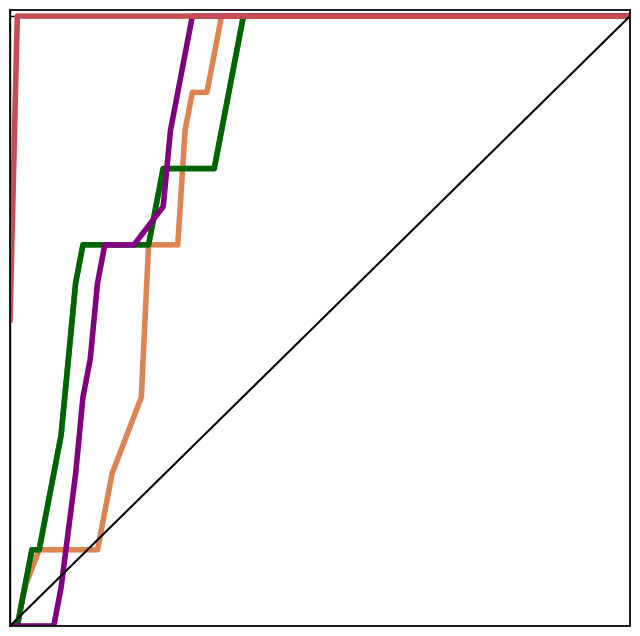

In [320]:
tmp = pd.concat( [ create_roc_dataset(predicted_conts, a, perc1_abund=200)
                   for a in predicted_conts.columns[2:] ] ).reset_index(drop=True)

tmp_pal={ b:global_palette[a] for a,b in zip(tmp.Method.unique(),
                                                          tmp['Full Method'].unique()) }

plt.figure(figsize=(8,8))

plt.rcParams["font.family"] = "calibri"
plt.figure(figsize=(8,8))
ax=sns.lineplot("FPR", 
                "TPR", 
                hue='Full Method',
                data = tmp, 
                linewidth=4, 
                palette=tmp_pal, 
                ci=0
           )

sns.lineplot([0,1], [0,1], color = 'black')


plt.ylim(0,1.01)
plt.xlim(0,1)

hide_axes=True
if hide_axes:
        ax.legend().remove()
        plt.xlabel(None)
        plt.ylabel(None)
        plt.xticks(np.linspace(0,1,2), labels=[]*2)
        plt.yticks(np.linspace(0,1,2), labels=[]*2)
